# SimFin Tutorial 05 - Data Hubs

[Original repository on GitHub](https://github.com/simfin/simfin-tutorials)

This tutorial was originally written by [Hvass Labs](https://github.com/Hvass-Labs)

----

"I just have to type Y instead of Y-E-S ... Hey Miss-didn't-find-me-attractive-sexually-anymore, I just tripled my productivity!" &ndash; [The Simpsons](https://www.youtube.com/watch?v=R_rF4kcqLkI)

## Introduction

In the previous tutorials we saw how to download and load financial data from the SimFin server using the `sf.load` functions, how to resample and reindex the data using the `sf.resample` and `sf.reindex` functions, how to calculate growth-rates and stock-returns using the `sf.rel_change` and `sf.mean_log_change` functions, and finally how to combine all of this to calculate signals using functions like `sf.price_signals` and `sf.val_signals`.

Because we have to go through all these basic steps every time we want to work on the financial data, and this mostly consists of copy-pasting our previous code, the simfin package provides what we call *Data Hubs* to do most of the work for us.

The data-hub also uses disk-caching for its slow computations, so the results are automatically saved to disk and will be reloaded very quickly the next time the slow functions are called. The data-hub also ensures the disk-cache is updated whenever new datasets are downloaded from the SimFin server. The data-hub's functions are also RAM-cached, so the second time you call them, they return the results nearly instantly.

Altogether, the data-hub makes it much easier and faster to work with the financial data.

It is not strictly necessary for you to be familiar with the previous tutorials on the basics of simfin, but it is helpful because you would have a better understanding of what exactly the data-hub is doing.

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [2]:
# Version of the SimFin Python API.
sf.__version__

'0.3.0'

## Config

In [3]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [4]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [5]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## Data Hub

In these examples, we are interested in US stock-market data for the tickers AAPL, AMZN and MSFT. We want to add a 60-day offset to the dates of the financial reports, to simulate the delay between the date of a financial report and when it was actually made available to the public. And finally we want to download the datasets from the SimFin server every 30 days, except for the share-prices which should be downloaded every 10 days.

In [6]:
# We are interested in the US stock-market.
market = 'us'

# List of tickers we want. If None then all tickers are used.
tickers = ['AAPL', 'AMZN', 'MSFT']

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

Using these settings, we can then create the data-hub object. This basically just creates and configures the data-hub. It does not load any data or perform any calculations at this point, so it returns nearly instantly.

In [7]:
%%time
hub = sf.StockHub(market=market, tickers=tickers, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices)

CPU times: user 20 µs, sys: 1 µs, total: 21 µs
Wall time: 23.4 µs


## Load Datasets

We can now use the data-hub to load financial datasets. This is very similar to the `sf.load` functions, except that we don't have to set the market-argument because that is already known by the data-hub. This is how we load the dataset with share-prices:

In [8]:
%%time
df_prices = hub.load_shareprices(variant='daily')

Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
CPU times: user 15.2 s, sys: 1.24 s, total: 16.4 s
Wall time: 14.9 s


In [9]:
df_prices.head()

SimFinId     Open      Low     High    Close  Adj. Close  \
Ticker Date                                                                   
AAPL   2007-01-03    111052  12.3271  11.7000  12.3686  11.9714       10.42   
       2007-01-04    111052  12.0071  11.9743  12.2786  12.2371       10.65   
       2007-01-05    111052  12.2529  12.0571  12.3143  12.1500       10.57   
       2007-01-08    111052  12.2800  12.1829  12.3614  12.2100       10.62   
       2007-01-09    111052  12.3500  12.1643  13.2829  13.2243       11.51   

                   Dividend     Volume  
Ticker Date                             
AAPL   2007-01-03       NaN   44225700  
       2007-01-04       NaN   30259300  
       2007-01-05       NaN   29812200  
       2007-01-08       NaN   28468100  
       2007-01-09       NaN  119617800

Note what happens if we call the exact same function again with the exact same argument - it returns the exact same result almost instantly. This is because the data-hub uses a RAM-cache for most of its functions, so the DataFrame is just taken from RAM instead of being reloaded from disk.

In [10]:
%%time
df_prices = hub.load_shareprices(variant='daily')

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 12.4 µs


We can also use the data-hub to load other datasets such as the TTM Income Statements:

In [11]:
%%time
df_income_ttm = hub.load_income(variant='ttm')

Dataset "us-income-ttm" on disk (6 days old).
- Loading from disk ... Done!
CPU times: user 307 ms, sys: 12.2 ms, total: 320 ms
Wall time: 317 ms


In [12]:
df_income_ttm.head()

SimFinId Currency  Fiscal Year Fiscal Period Publish Date  \
Ticker Report Date                                                              
AAPL   2010-03-31     111052      USD         2010            Q2   2010-04-21   
       2010-06-30     111052      USD         2010            Q3   2010-07-21   
       2010-09-30     111052      USD         2010            Q4   2010-10-27   
       2010-12-31     111052      USD         2011            Q1   2011-01-19   
       2011-03-31     111052      USD         2011            Q2   2011-04-21   

                    Shares (Basic)  Shares (Diluted)       Revenue  \
Ticker Report Date                                                   
AAPL   2010-03-31     6.304956e+09      6.415840e+09  5.112300e+10   
       2010-06-30     6.337305e+09      6.447691e+09  5.708900e+10   
       2010-09-30     6.366227e+09      6.472984e+09  6.522500e+10   
       2010-12-31     6.393793e+09      6.496383e+09  7.628300e+10   
       2011-03-31     6.421177e+09      6.519249e+09  8.745100e+10   

                    Cost of Revenue  Gross Profit  ...  \
Ticker Report Date                                 ...   
AAPL   2010-03-31     -2.999900e+10  2.112400e+10  ...   
       2010-06-30     -3.381200e+10  2.327700e+10  ...   
       2010-09-30     -3.954100e+10  2.568400e+10  ...   
       2010-12-31     -4.671200e+10  2.957100e+10  ...   
       2011-03-31     -5.328700e+10  3.416400e+10  ...   

                    Non-Operating Income (Loss)  Interest Expense, Net  \
Ticker Report Date                                                       
AAPL   2010-03-31                   188000000.0                    NaN   
       2010-06-30                   186000000.0                    NaN   
       2010-09-30                   155000000.0                    NaN   
       2010-12-31                   258000000.0                    NaN   
       2011-03-31                   234000000.0                    NaN   

                    Pretax Income (Loss), Adj.  Abnormal Gains (Losses)  \
Ticker Report Date                                                        
AAPL   2010-03-31                  15208000000                      NaN   
       2010-06-30                  16808000000                      NaN   
       2010-09-30                  18540000000                      NaN   
       2010-12-31                  21745000000                      NaN   
       2011-03-31                  25616000000                      NaN   

                    Pretax Income (Loss)  Income Tax (Expense) Benefit, Net  \
Ticker Report Date                                                            
AAPL   2010-03-31            15208000000                      -4.396000e+09   
       2010-06-30            16808000000                      -4.571000e+09   
       2010-09-30            18540000000                      -4.527000e+09   
       2010-12-31            21745000000                      -5.106000e+09   
       2011-03-31            25616000000                      -6.064000e+09   

                    Income (Loss) from Continuing Operations  \
Ticker Report Date                                             
AAPL   2010-03-31                                10812000000   
       2010-06-30                                12237000000   
       2010-09-30                                14013000000   
       2010-12-31                                16639000000   
       2011-03-31                                19552000000   

                    Net Extraordinary Gains (Losses)   Net Income  \
Ticker Report Date                                                  
AAPL   2010-03-31                                NaN  10812000000   
       2010-06-30                                NaN  12237000000   
       2010-09-30                                NaN  14013000000   
       2010-12-31                                NaN  16639000000   
       2011-03-31                                NaN  19552000000   

                    Ne

Again we see that the function returns nearly instantly when we call it the second time, provided the argument is exactly the same, because then the DataFrame is merely taken from the RAM-cache instead of being reloaded from disk:

In [13]:
%%time
df_income_ttm = hub.load_income(variant='ttm')

CPU times: user 12 µs, sys: 1e+03 ns, total: 13 µs
Wall time: 16.9 µs


## RAM-Cache Warning

Because the data-hub uses a RAM-cache for its functions, it means that you should **NEVER** modify the DataFrames returned by the data-hub's functions, because that would modify the DataFrames stored in the RAM-cache, which may interfere with the data-hubs' other functions that use the same data. If you want to modify the DataFrames returned by the data-hub, you should **ALWAYS** make a copy first!

In [14]:
# Load the share-prices.
df_prices = hub.load_shareprices(variant='daily')

# Now we want to set the Closing share-prices to zero.

# This is BAD because it changes the contents of the RAM-cache
# inside the hub-object.
# df_prices[CLOSE] = 0.0

# This is fine because it only changes a copy of the data, so
# the RAM-cache inside the hub-object remains unchanged.
df_prices2 = df_prices.copy()
df_prices2[CLOSE] = 0.0

Although it is possible to clear the RAM-cache for the data-hubs' functions using the following command, it is recommended that you simply create a new data-hub and start over, if you accidentally modified any of the DataFrames returned by the data-hub.

In [15]:
# Clear the RAM-cache for the function.
# hub.load_shareprices.cache_clear()

## Calculate Signals

The benefits of the data-hub are much greater for the functions that calculate signals such as valuation ratios, moving averages of the share-prices, sales and earnings growth, etc. The data-hub makes the syntax much simpler for these functions, because you only need to call a single function, which then loads the required datasets (or takes them from the RAM-cache if they have already been loaded), and then passes the datasets along with other relevant arguments to the lower-level functions that perform the actual computations.

Furthermore, the data-hub also uses a disk-cache for its slow functions, so the results are automatically saved to a file on disk, which can be reloaded very quickly the next time you call the function. The cache-files are automatically updated by recomputing the slow functions, whenever the relevant datasets are downloaded again from the SimFin server.

The disk-cache works in addition to the RAM-cache, so the data-hub uses two layers of caching to return the data as fast as possible, when the data does not have to be reloaded or calculated again.

The filenames used by the disk-cache are automatically set from all the arguments to the data-hub and its functions, using a hashing-function that creates a short but nearly unique ID code, so the cache-files are kept separate when you call the same function but with different arguments.

### Price Signals

This is how easily we may calculate price signals such as Moving Averages. Note that the function finished very quickly because we are only using data for 3 stocks, so there is no need for the disk-cache here. But if we had not specified a list of tickers when creating the data-hub object, this function would calculate the signals for thousands of stocks, which takes a while to compute, so the disk-cache is often very useful.

In [16]:
%%time
df_price_signals = hub.price_signals()

Cache-file 'price_signals-d03458cf.pickle' not on disk.
- Running function price_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 53.4 ms, sys: 100 µs, total: 53.5 ms
Wall time: 55.5 ms


In [17]:
df_price_signals.head()

EMA      MACD  MACD-EMA  MAVG 20  MAVG 200
Ticker Date                                                        
AAPL   2007-01-03  11.971400  0.000000  0.000000      NaN       NaN
       2007-01-04  12.110893  0.005961  0.003312      NaN       NaN
       2007-01-05  12.125253  0.004895  0.003961      NaN       NaN
       2007-01-08  12.149718  0.006456  0.004806      NaN       NaN
       2007-01-09  12.409650  0.047530  0.017515      NaN       NaN

### Volume Signals

This is how easily we may calculate the volume signals:

In [18]:
%%time
df_vol_signals = hub.volume_signals(window=20)

Cache-file 'volume_signals-0eb21bf8.pickle' not on disk.
- Running function volume_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 164 ms, sys: 12 ms, total: 176 ms
Wall time: 173 ms


If we call the same function with a different argument, then the data-hub automatically changes the cache-name so as to keep the different results in separate cache-files:

In [19]:
%%time
df_vol_signals2 = hub.volume_signals(window=30)

Cache-file 'volume_signals-6bc2fe28.pickle' not on disk.
- Running function volume_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 141 ms, sys: 7.76 ms, total: 149 ms
Wall time: 145 ms


In [20]:
df_vol_signals.dropna(how='all').head()

Relative Volume  Volume Market-Cap  Volume Turnover
Ticker Date                                                           
AAPL   2007-01-31        -0.463248       6.263896e+08              NaN
       2007-02-01        -0.695482       6.142787e+08              NaN
       2007-02-02        -0.753584       6.092018e+08              NaN
       2007-02-05        -0.814985       6.034860e+08              NaN
       2007-02-06        -0.416573       6.046619e+08              NaN

### Financial Signals

The following shows how easily we may calculate financial signals such as Current Ratio, Debt Ratio, Net Profit Margin, etc. The function's argument `variant` determines the frequency of the resulting data-points:

- `variant=daily` means the result has daily data-points for the same dates as the share-prices. By default this uses forward-filling with the last-known values, but this can be changed with the `fill_method` argument when constructing the data-hub.

- `variant=latest` means the result only has data-points for the last date of the share-prices. This is much faster to compute than daily data-points.

- `variant=quarterly` means the result has 4 data-points per year for the same dates as the company's quarterly financial reports (with the report date shifted if the `offset` argument was given when the data-hub object was created).

In [21]:
%%time
df_fin_signals_daily = hub.fin_signals(variant='daily')

Dataset "us-balance-ttm" on disk (6 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-c549b5bd.pickle' not on disk.
- Running function fin_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 408 ms, sys: 4.2 ms, total: 412 ms
Wall time: 408 ms


In [22]:
df_fin_signals_daily.dropna(how='all').head()

Current Ratio  Debt Ratio  Gross Profit Margin  \
Ticker Date                                                         
AAPL   2010-06-01       2.644206         NaN               0.4132   
       2010-06-02       2.644206         NaN               0.4132   
       2010-06-03       2.644206         NaN               0.4132   
       2010-06-04       2.644206         NaN               0.4132   
       2010-06-07       2.644206         NaN               0.4132   

                   Net Profit Margin  Return on Assets  Return on Equity  
Ticker Date                                                               
AAPL   2010-06-01            0.21149               NaN               NaN  
       2010-06-02            0.21149               NaN               NaN  
       2010-06-03            0.21149               NaN               NaN  
       2010-06-04            0.21149               NaN               NaN  
       2010-06-07            0.21149               NaN               NaN

### Growth Signals

The following shows how easily we may calculate growth-signals. This function also takes the argument `variant` which has the same meaning as for the `fin_signals` function above. For example, when `variant=quarterly` it creates 4 data-points per yer:

In [23]:
%%time
df_growth_signals_qrt = hub.growth_signals(variant='quarterly')

Dataset "us-income-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (26 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-70589cd4.pickle' not on disk.
- Running function growth_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 1.01 s, sys: 19.7 ms, total: 1.03 s
Wall time: 1.02 s


In [24]:
df_growth_signals_qrt.dropna(how='all').head()

Earnings Growth  Earnings Growth QOQ  Earnings Growth YOY  \
Ticker Report Date                                                              
AAPL   2009-11-29               NaN             0.385120                  NaN   
       2010-03-01               NaN             0.334123                  NaN   
       2010-05-30               NaN            -0.089994                  NaN   
       2010-08-29               NaN             0.058230             0.779540   
       2010-11-29               NaN             0.324316             0.701422   

                    FCF Growth  FCF Growth QOQ  FCF Growth YOY  Sales Growth  \
Ticker Report Date                                                             
AAPL   2009-11-29          NaN        0.320320             NaN           NaN   
       2010-03-01          NaN        1.047005             NaN           NaN   
       2010-05-30          NaN       -0.624259             NaN           NaN   
       2010-08-29          NaN        1.057664        1.089590           NaN   
       2010-11-29          NaN        0.166467        0.846096           NaN   

                    Sales Growth QOQ  Sales Growth YOY  
Ticker Report Date                                      
AAPL   2009-11-29           0.254058               NaN  
       2010-03-01           0.284755               NaN  
       2010-05-30          -0.139259               NaN  
       2010-08-29           0.163049          0.612903  
       2010-11-29           0.295732          0.666503

If we change the argument to `variant='daily'` then we get daily data-points where the growth-rates have been forward-filled from the last-known values (this may be changed by setting the argument `fill_method` when constructing the data-hub object). Note that the cache-filename is different to keep the files separate.

In [25]:
%%time
df_growth_signals_daily = hub.growth_signals(variant='daily')

Cache-file 'growth_signals-c549b5bd.pickle' not on disk.
- Running function growth_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 187 ms, sys: 4.5 ms, total: 192 ms
Wall time: 186 ms


In [26]:
df_growth_signals_daily.dropna(how='all').head()

Earnings Growth  Earnings Growth QOQ  Earnings Growth YOY  \
Ticker Date                                                                    
AAPL   2009-11-30              NaN              0.38512                  NaN   
       2009-12-01              NaN              0.38512                  NaN   
       2009-12-02              NaN              0.38512                  NaN   
       2009-12-03              NaN              0.38512                  NaN   
       2009-12-04              NaN              0.38512                  NaN   

                   FCF Growth  FCF Growth QOQ  FCF Growth YOY  Sales Growth  \
Ticker Date                                                                   
AAPL   2009-11-30         NaN         0.32032             NaN           NaN   
       2009-12-01         NaN         0.32032             NaN           NaN   
       2009-12-02         NaN         0.32032             NaN           NaN   
       2009-12-03         NaN         0.32032             NaN           NaN   
       2009-12-04         NaN         0.32032             NaN           NaN   

                   Sales Growth QOQ  Sales Growth YOY  
Ticker Date                                            
AAPL   2009-11-30          0.254058               NaN  
       2009-12-01          0.254058               NaN  
       2009-12-02          0.254058               NaN  
       2009-12-03          0.254058               NaN  
       2009-12-04          0.254058               NaN

### Valuation Signals

The following shows how easily we may calculate valuation signals such as P/E and P/Sales ratios. This requires several datasets, but most of them have already been loaded by the data-hub in the function-calls we ran above, so the datasets are merely taken from the RAM-cache instead of being loaded again.

By setting `variant='latest'` we only calculate the valuation signals for the latest day of the share-prices. This is much faster than calculating the signals for daily data-points, and is useful e.g. when making a stock-screener:

In [27]:
%%time
df_val_signals_latest = hub.val_signals(variant='latest')

Dataset "us-shareprices-latest" on disk (2 days old).
- Loading from disk ... Done!
Cache-file 'val_signals-cac8146c.pickle' not on disk.
- Running function val_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 68.1 ms, sys: 284 µs, total: 68.4 ms
Wall time: 66.2 ms


In [28]:
df_val_signals_latest.head()

,,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
Ticker,Date,,,,,,,,,,
AAPL,2019-12-20,0.010868,0.042534,0.045336,1.299092e+12,14.356514,23.510429,22.057394,-15.245951,-10.131468,4.993167
AMZN,2019-12-20,NaN,0.012640,0.022334,8.977162e+11,15.886534,79.114854,44.773878,-14.129031,-11.637230,3.381636
MSFT,2019-12-20,0.011575,0.033733,0.031717,1.218196e+12,11.485805,29.644133,31.528443,-174.077735,-59.044724,9.384165


We may also calculate the valuation signals for daily data-points, simply by setting the argument `variant='daily'`:

In [29]:
%%time
df_val_signals_daily = hub.val_signals(variant='daily')

Cache-file 'val_signals-a6127cfd.pickle' not on disk.
- Running function val_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 222 ms, sys: 11.8 ms, total: 234 ms
Wall time: 229 ms


In [30]:
df_val_signals_daily.dropna(how='all').head()

Dividend Yield  Earnings Yield  FCF Yield    Market-Cap  \
Ticker Date                                                                  
AAPL   2010-06-01             NaN        0.045227   0.050468  2.390632e+11   
       2010-06-02             NaN        0.044692   0.049871  2.419227e+11   
       2010-06-03             NaN        0.044833   0.050029  2.411624e+11   
       2010-06-04             NaN        0.046086   0.051427  2.346042e+11   
       2010-06-07             NaN        0.047009   0.052457  2.299989e+11   

                     P/Book        P/E      P/FCF     P/NCAV   P/NetNet  \
Ticker Date                                                               
AAPL   2010-06-01  6.075612  22.110910  19.814601  16.343964  30.148580   
       2010-06-02  6.148285  22.375389  20.051612  16.539461  30.509200   
       2010-06-03  6.128963  22.305071  19.988597  16.487484  30.413320   
       2010-06-04  5.962289  21.698497  19.445019  16.039116  29.586248   
       2010-06-07  5.845249  21.272555  19.063312  15.724268  29.005469   

                    P/Sales  
Ticker Date                  
AAPL   2010-06-01  4.676235  
       2010-06-02  4.732170  
       2010-06-03  4.717298  
       2010-06-04  4.589014  
       2010-06-07  4.498931

## Calculate Returns

The data-hub also provides functions for easily calculating stock-returns for different investment durations. Let us first calculate the annualized future stock-returns for all 3-year investment periods.

In [31]:
# Name of the new Pandas Series with the stock-returns.
TOTAL_RETURN_3Y = 'Total Return 3-Year'

In [32]:
%%time
df_returns_3y = hub.returns(name=TOTAL_RETURN_3Y, years=3,
                            future=True, annualized=True)

Cache-file 'rel_change-2ab9d7a6.pickle' not on disk.
- Running function rel_change() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 14 ms


For example, the calculated return for AAPL on 2007-01-03 is 0.359641, which means that between 2007-01-03 and 2010-01-03 (or the closest trading-day), the annualized return was about 35.96% per year. This is the so-called Total Return which assumes dividends are reinvested without having to pay any taxes.

In [33]:
df_returns_3y.loc['AAPL']['2007-01-03':'2007-01-09']

Date
2007-01-03    0.359641
2007-01-04    0.356789
2007-01-05    0.360885
2007-01-08    0.351568
2007-01-09    0.314955
Name: Total Return 3-Year, dtype: float64

We can also plot these 3-year annualized returns for the AAPL stock:

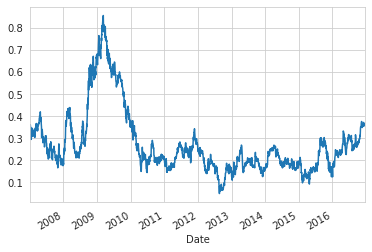

In [34]:
df_returns_3y.loc['AAPL'].dropna().plot(grid=True)

### Mean-Log Returns

It is often useful to consider the average returns e.g. over 1-3 year periods. It is much faster to compute the mean-log returns, and the results are close to the mean returns.

In [35]:
# Name of the new Pandas Series with the stock-returns.
TOTAL_RETURN_1_3Y = 'Total Return 1-3 Years'

In [36]:
%%time
df_returns_1_3y = \
    hub.mean_log_returns(name=TOTAL_RETURN_1_3Y,
                         min_years=1, max_years=3,
                         future=True, annualized=True)

Cache-file 'mean_log_change-257ab99e.pickle' not on disk.
- Running function mean_log_change() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 71.1 ms, sys: 199 µs, total: 71.3 ms
Wall time: 69.3 ms


For ticker AAPL, the mean-log return was 0.277523 for all 1-3 year investment periods between 2007-01-03 and 2010-01-03. This means that if you had bought AAPL stock on 2007-01-03 and sold them somewhere between 2008-01-03 and 2010-01-03, then on average you would have made roughly 28% per year, depending on exactly when you had sold the stocks in this 1-3 year period. Note that the mean-log return corresponds roughly to the (non-log) mean returns for values in this range.

In [37]:
df_returns_1_3y.loc['AAPL']['2007-01-03':'2007-01-09']

Date
2007-01-03    0.277523
2007-01-04    0.265312
2007-01-05    0.269260
2007-01-08    0.266535
2007-01-09    0.222106
Name: Total Return 1-3 Years, dtype: float64

We can also plot the mean-log returns for 1-3 year investment periods for the AAPL stock:

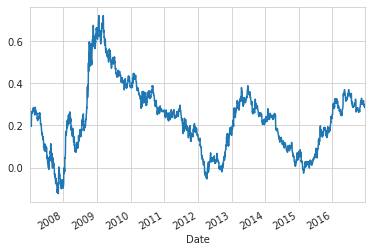

In [38]:
df_returns_1_3y.loc['AAPL'].dropna().plot(grid=True)

## Combine Signals and Returns

Let us now combine the stock-returns and the signals we are interested in, into a single DataFrame that is easier to work with:

In [39]:
# List of all the DataFrames with different signals.
dfs = [df_price_signals, df_fin_signals_daily,
       df_growth_signals_daily, df_val_signals_daily]

# Combine all the signal DataFrames into a single DataFrame.
df_all_signals = pd.concat(dfs, axis=1)

# DataFrame with the signals we are interested in, for example.
signals = [PE, PSALES, CURRENT_RATIO, MAVG_20]
df_signals = df_all_signals[signals]

# DataFrame with the signals and stock-returns.
dfs = [df_signals, df_returns_3y, df_returns_1_3y]
df_combined = pd.concat(dfs, axis=1)

# Remove rows with any NaN values.
df_combined = df_combined.dropna(how='any')

In [40]:
df_combined.head()

P/E   P/Sales  Current Ratio    MAVG 20  \
Ticker Date                                                        
AAPL   2010-06-01  22.110910  4.676235       2.644206  35.883590   
       2010-06-02  22.375389  4.732170       2.644206  35.921230   
       2010-06-03  22.305071  4.717298       2.644206  35.972195   
       2010-06-04  21.698497  4.589014       2.644206  36.041585   
       2010-06-07  21.272555  4.498931       2.644206  36.149300   

                   Total Return 3-Year  Total Return 1-3 Years  
Ticker Date                                                     
AAPL   2010-06-01             0.207653                0.314334  
       2010-06-02             0.203691                0.308274  
       2010-06-03             0.203844                0.310623  
       2010-06-04             0.211123                0.326294  
       2010-06-07             0.213025                0.337643

We can then plot e.g. the P/Sales ratios versus the future 1-3 year stock-returns:

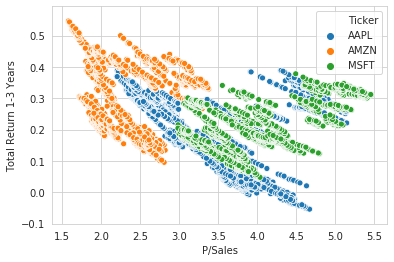

In [41]:
sns.scatterplot(x=PSALES, y=TOTAL_RETURN_1_3Y, hue=TICKER,
                data=df_combined.reset_index())

### NumPy Arrays

If you want to use the signals and stock-returns with functions that accept NumPy arrays instead of Pandas DataFrames, it is very easy to convert from Pandas to NumPy, because Pandas uses NumPy internally:

In [42]:
# Get the numpy array with the signals and stock-returns
# from the Pandas DataFrame.
arr = df_combined.values

# Number of signals in the DataFrame.
num_signals = 4

# Numpy array with the signals.
arr_signals = arr[:, :num_signals]

# Numpy array with the returns.
arr_returns = arr[:, num_signals:]

This is the NumPy array with the signals that we are interested in:

In [43]:
arr_signals

array([[22.11091028,  4.676235  ,  2.64420639, 35.88359   ],
       [22.37538861,  4.73216951,  2.64420639, 35.92123   ],
       [22.30507072,  4.71729798,  2.64420639, 35.972195  ],
       ...,
       [23.28061866,  5.35009978,  2.68507057, 61.045     ],
       [23.77388378,  5.46345663,  2.68507057, 61.2085    ],
       [23.74398892,  5.45658652,  2.68507057, 61.3425    ]])

In [44]:
arr_signals.shape

(4959, 4)

This is the NumPy array with the two kinds of stock-returns that we calculated:

In [45]:
arr_returns

array([[0.20765287, 0.31433411],
       [0.2036908 , 0.30827427],
       [0.20384442, 0.31062266],
       ...,
       [0.37773349, 0.32155831],
       [0.37209097, 0.31072557],
       [0.37767608, 0.31214757]])

In [46]:
arr_returns.shape

(4959, 2)

Because the two NumPy arrays have the same number of rows, they can easily be fed into different Machine Learning libraries, which we might do in a future tutorial.

## License (MIT)

This is published under the
[MIT License](https://github.com/simfin/simfin-tutorials/blob/master/LICENSE.txt)
which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/simfin/simfin-tutorials).
